## Normalizing Flows - Exercise 6.
### Daniel Aibinder 318239639, Yonathan Dovgolevsky 327709648

In [1]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\Danny\AppData\Local\Temp\ipykernel_20708\3028478413.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Using device cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:
def add_noise(sample):
    sample = (sample * 255).to(torch.float) # Convert to float and scale to [0, 255]
    noise = torch.rand_like(sample) # Uniform noise in [0, 1]
    noisy_sample = sample + noise
    noisy_sample = noisy_sample / 255.0 # Scale back to [0, 1]
    noisy_sample = torch.clamp(noisy_sample, 0, 1) # Ensure that the values are still in [0, 1]
    return noisy_sample

def flatten_image(image):
    return image.view(-1)

# Transformations: Convert to tensor, add noise and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    add_noise,
    flatten_image
])


# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False)

Global seed set to 42


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


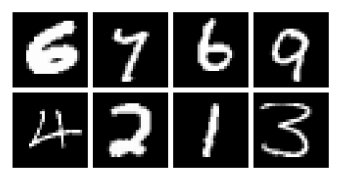

In [3]:
def show_imgs(imgs, nrow_num = 4):
    imgs = [img.view(1, 28, 28) for img in imgs] #unflatten images
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, nrow_num)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4 ),
            nn.ReLU(),
            nn.Linear(input_dim // 4 , input_dim // 4 ),
            nn.ReLU(),
            nn.Linear(input_dim // 4 , input_dim // 2 ),
            nn.ReLU(),
            nn.Linear(input_dim // 2 , input_dim)
        )


    def forward(self, x):
        self.to(x.device)
        return self.layers(x)

class NormalizingFlowLayer2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.mlp = MLP(input_dim // 2)
        self.scale = nn.Parameter(torch.randn(input_dim, device=device) * 0.01).to(device)

    def forward(self, x, alternate, inverse = False):
        intermediate_outputs = []
        x = x.to(device)
        if not inverse:
            x1, x2 = torch.chunk(x, 2, dim=-1)
            if alternate:
                x2 = x2 + self.mlp(x1)
            else:
                x1 = x1 + self.mlp(x2)
            x = torch.cat([x1, x2], dim=1)
            x = x * torch.exp(self.scale.to(device))
            intermediate_outputs.append(x.clone().detach())
            logdet = torch.sum(self.scale, dim=-1)
        else:
            x = x * torch.exp(-self.scale.to(device))
            x1, x2 = torch.chunk(x, 2, dim=1)
            if alternate:
                x2 = x2 - self.mlp(x1)
            else:
                x1 = x1 - self.mlp(x2)
            x = torch.cat([x1, x2], dim=1)
            intermediate_outputs.append(x.clone().detach())
            logdet = -torch.sum(self.scale, dim=-1)
        return x, logdet, intermediate_outputs


class NormalizingFlowModel2(pl.LightningModule):
    def __init__(self,input_dim, num_flows):
        super().__init__()
        self.input_dim = input_dim
        self.num_flows = num_flows
        self.transforms = nn.ModuleList([NormalizingFlowLayer2(input_dim) for _ in range(num_flows)])

    def forward(self, x):
        intermediate_outputs = []
        logdet = torch.zeros(x.shape[0], device=x.device)
        alternate = False
        for transform in self.transforms:
            x, ld, intermediates = transform(x, alternate)
            logdet += ld
            alternate = not alternate
            intermediate_outputs.append(intermediates)
        return x, logdet, intermediate_outputs

    def inverse(self, x):
        logdet = torch.zeros(x.shape[0], device=x.device)
        alternate = True
        intermediate_outputs = []
        for transform in reversed(self.transforms):
            x, ld, intermediates = transform(x, alternate, inverse=True)
            logdet += ld
            alternate = not alternate
            intermediate_outputs.insert(0, intermediates)
        return x, logdet, intermediate_outputs

    def calc_likelihood(self, x):
        z, logdet, _ = self.forward(x)
        logdet = torch.mean(logdet)
        norm = - 0.5  * self.input_dim * math.log(2 * math.pi)
        logPz = torch.mean(-0.5 * torch.sum(z**2, dim=-1)) + norm
        return logPz + logdet

    @torch.no_grad()
    def sample(self, num_samples):
        z = torch.randn(num_samples, self.input_dim, device=device)
        x,_,_ = self.inverse(z)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('train_log_likelihood', log_likelihood)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('val_log_likelihood', log_likelihood)
        return loss

    def test_step(self, batch, batch_idx):
        x, _ = batch
        log_likelihood = self.calc_likelihood(x).mean()
        loss = -log_likelihood
        self.log('test_log_likelihood', log_likelihood)
        return loss


In [5]:
def train_model(use_pretrained = False, pretrained_path = "", **kwargs):
    logger = TensorBoardLogger("tb_logs", name="Flows-ex6")
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "Flows-ex6"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         logger = logger,
                         max_epochs=150,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_log_likelihood"),
                                    LearningRateMonitor("epoch")])
    result = None

    # Check whether pretrained model exists. If yes, load it and skip training
    if os.path.isfile(pretrained_path) and use_pretrained:
        print("Found pretrained model, loading...")
        model = NormalizingFlowModel2.load_from_checkpoint(pretrained_path, **kwargs)
        ckpt = torch.load(pretrained_path, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = NormalizingFlowModel2(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)

    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [6]:
#All graphs taken from tensorboard

%load_ext tensorboard
%tensorboard --logdir tb_logs

In [7]:
# QUESTION 1 TRAIN
pretrained_path = "tb_logs\\Flows-ex6\\q1\\epoch=34-step=13650.ckpt"
model, result = train_model(input_dim = 28*28, num_flows = 4, use_pretrained=True, pretrained_path=pretrained_path)
test_res = result["test"][0]
print("test_log_likelihood: %4.3f" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_log_likelihood"]))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | transforms | ModuleList | 813 K 
------------------------------------------
813 K     Trainable params
0         Non-trainable params
813 K     Total params
3.255     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Danny\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

test_log_likelihood: 1510.095


## Results
Note that we tracked the log likelihood and not the negative log likelhood. the negative log graph is the same but goes down. </br>
Each normalizing flow layer is essentially a affine shift that transforms the distribution of data to several modes learning the probability denstiy function.</br>
Each transformation is invertible and is can be used to sample from the model.</br>
We followed the excerice where we split our input data x into 2 chunks. where 1 half was used for the MLP layer and the other half concatanted back afterwards to complete our x.</br>
We implemented the inverse function that does the exact same only that it performs all mathematical operations in reverse. and starts with the last layer back to the first.</br>
The loss function is the log probability of the transofrmed variable z under a standard normal distribution. we added a normalizing factor so that the gaussian integrates to 1. </br>
We then combine the log determinant of the jacobian of the transformation that we get from our models forward function to get the final loss.

<img src="https://raw.githubusercontent.com/daiyral/ex6/main/plots/train_loss.png" alt="Training log likelihood" width="1000"/>
<img src="https://raw.githubusercontent.com/daiyral/ex6/main/plots/val_loss.png" alt="Training log likelihood" width="1000"/>

Global seed set to 5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


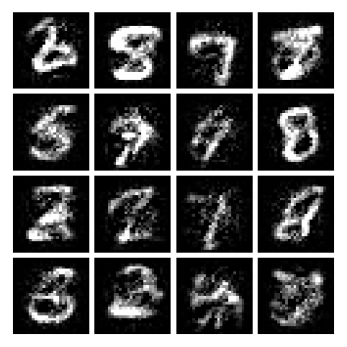

In [14]:
pl.seed_everything(5)
samples = model.sample(num_samples=16)
show_imgs(samples.cpu())

## Question 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


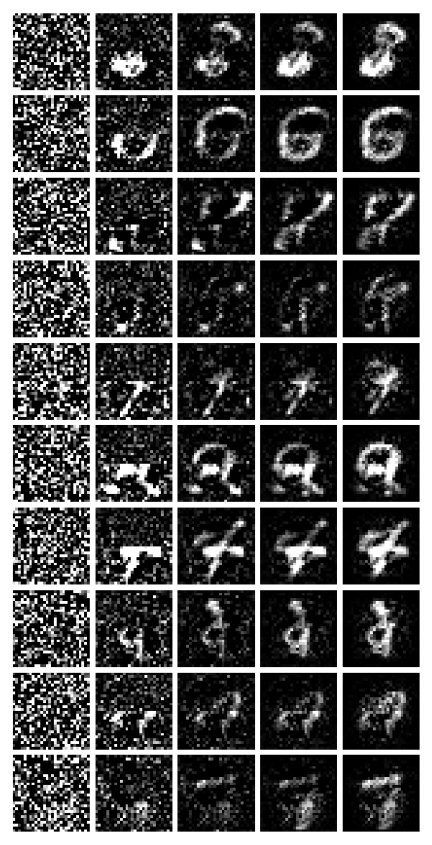

In [15]:
def q2(num_samples=10):
    model.eval()
    with torch.no_grad():
        z_samples = torch.randn(num_samples, model.input_dim, device=device)
        all_outputs = []
        for z in z_samples:
            z = z.unsqueeze(0)
            _, _, intermediates = model.inverse(z)
            intermediates = [z] + intermediates[::-1] 
            all_outputs.append(intermediates)

        flat_outputs = [output for sample_outputs in all_outputs for output in sample_outputs]

        reshaped_outputs = []
        for output in flat_outputs:
            if isinstance(output, list):
                output = output[0]  
            try:
                reshaped_outputs.append(output.view(1, 28, 28))  
            except RuntimeError as e:
                print(f"Error reshaping tensor: {e}")


        show_imgs(reshaped_outputs, nrow_num=5)

q2()

## Question 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


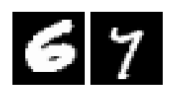

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


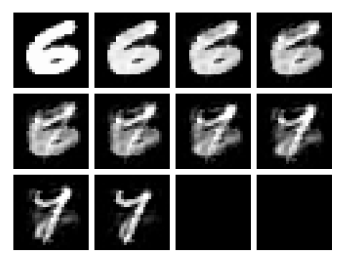

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


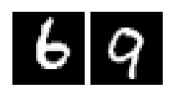

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


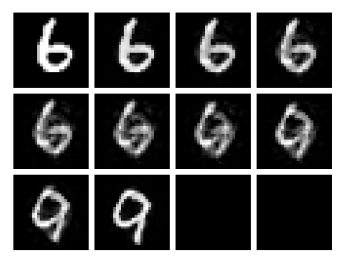

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


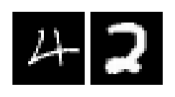

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


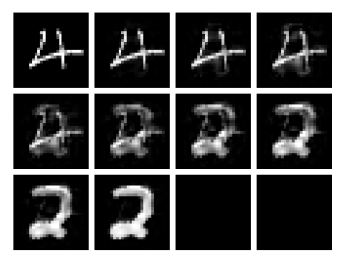

In [16]:
def q3(i, j):
  img1, img2 = train_set[i][0], train_set[j][0]
  show_imgs([img1, img2])
  with torch.no_grad():
    z1, _, _ = model(img1.unsqueeze(0).to(device))
    z2, _, _ = model(img2.unsqueeze(0).to(device))
    imgs = torch.zeros(12, 1, 28, 28)
    for k in range(10):
        img_recon, _, _ = model.inverse(z1 * (1 - k / 10.0) + z2 * k / 10.0)
        imgs[k] = img_recon.view(1, 1, 28, 28)
    show_imgs(imgs.cpu())
q3(0, 1)
q3(2, 3)
q3(4, 5)